In [1]:
# Run this cell first and wait for it to finish.
!pip install protobuf==3.20.3
!pip install gymnasium==0.29.1
!pip install stable_baselines3==2.2.1
!pip install shimmy>=0.2.1

# RL Null-Sterring  and Beamforming Agent 

## train and val logic

In [15]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt


class AntennaArrayPhysics:
    def __init__(self, num_elements):
        self.N = num_elements
        self.d_lambda = 0.5 
        self.k = 2 * np.pi
        self.sigma_signal = 1.0   
        self.sigma_jammer = 10.0  
        self.sigma_noise = 0.1    
        self.snapshots = 64        

    def steering_vector(self, theta_deg):
        theta_rad = np.radians(theta_deg)
        n = np.arange(self.N)
        psi = self.k * self.d_lambda * np.cos(theta_rad)
        return np.exp(1j * n.reshape(-1, 1) * psi)

    def compute_scm(self, theta_user, theta_jammer):
        a_user = self.steering_vector(theta_user)
        a_jam = self.steering_vector(theta_jammer)
        s_user = (np.random.randn(1, self.snapshots) + 1j * np.random.randn(1, self.snapshots)) * np.sqrt(self.sigma_signal/2)
        s_jam = (np.random.randn(1, self.snapshots) + 1j * np.random.randn(1, self.snapshots)) * np.sqrt(self.sigma_jammer/2)
        noise = (np.random.randn(self.N, self.snapshots) + 1j * np.random.randn(self.N, self.snapshots)) * np.sqrt(self.sigma_noise/2)
        X = (a_user @ s_user) + (a_jam @ s_jam) + noise
        Rxx = (X @ X.conj().T) / self.snapshots
        return Rxx

    def array_factor_gain(self, theta_deg, weights):
        a = self.steering_vector(theta_deg)
        return np.abs(np.sum(np.conj(weights) * a.flatten()))**2

# --- Trajectories ---
def training_trajectory(step):
    return 20.0 + (step * 0.05) % 50.0

def stress_test_trajectory(step):
    """Fast sweep 30 -> 80 deg"""
    return 30.0 + (step * 0.5) % 50.0

def slow_test_trajectory(step):
    """Slow sweep"""
    return 30.0 + (step * 0.05) % 50.0


class OptimizedSIMOEnv(gym.Env):
    def __init__(self, num_elements=8, trajectory_fn=training_trajectory, randomize_params=True, stack_frames=5, scenario='sector'):
        super(OptimizedSIMOEnv, self).__init__() 
        self.N = num_elements
        self.num_arrays = 2 
        
        self.physics_1 = AntennaArrayPhysics(num_elements=self.N)
        self.physics_2 = AntennaArrayPhysics(num_elements=self.N)
        
        self.trajectory_fn = trajectory_fn
        self.randomize_params = randomize_params
        self.stack_frames = stack_frames
        self.scenario = scenario # 'fixed', 'sector', 'full'
        
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(self.N * self.num_arrays * 2,), dtype=np.float32)
        
        obs_per_array = (self.N * 2) + (self.N * 2) 
        self.frame_size = obs_per_array * self.num_arrays
        self.stacked_obs_dim = self.frame_size * self.stack_frames
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(self.stacked_obs_dim,), dtype=np.float32)
        
        self.obs_buffer = deque(maxlen=self.stack_frames)
        self.weights_1 = np.zeros(self.N, dtype=np.complex64)
        self.weights_2 = np.zeros(self.N, dtype=np.complex64)
        self.step_count = 0
        self.jammer_angle = 30.0
        self.user_angle = 90.0

    def _get_single_frame(self):
        Rxx1 = self.physics_1.compute_scm(self.user_angle, self.jammer_angle)
        scale1 = np.trace(Rxx1).real + 1e-6
        row1 = (Rxx1 / scale1)[0, :] 
        Rxx2 = self.physics_2.compute_scm(self.user_angle, self.jammer_angle)
        scale2 = np.trace(Rxx2).real + 1e-6
        row2 = (Rxx2 / scale2)[0, :]
        return np.concatenate([
            self.weights_1.real, self.weights_1.imag, self.weights_2.real, self.weights_2.imag, 
            row1.real, row1.imag, row2.real, row2.imag
        ]).astype(np.float32)

    def _get_stacked_obs(self):
        while len(self.obs_buffer) < self.stack_frames:
            last = self.obs_buffer[-1] if self.obs_buffer else self._get_single_frame()
            self.obs_buffer.append(last)
        return np.concatenate(list(self.obs_buffer)).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        
        # Initialization
        self.weights_1 = (np.random.randn(self.N) + 1j * np.random.randn(self.N)).astype(np.complex64) * 0.5
        self.weights_2 = (np.random.randn(self.N) + 1j * np.random.randn(self.N)).astype(np.complex64) * 0.5
        self.obs_buffer.clear()
        
        if self.randomize_params:
            jam_pow = float(np.random.randint(10, 80))
            self.physics_1.sigma_jammer = jam_pow
            self.physics_2.sigma_jammer = jam_pow
            
            # Scenario Logic
            if self.scenario == 'fixed':
                self.user_angle = 90.0
                self.jammer_angle = float(np.random.randint(20, 60))
                
            elif self.scenario == 'sector':
                # Generalization Training (60 to 120)
                self.user_angle = float(np.random.uniform(60, 120))
                # Keep Jammer somewhat separated to allow learning (0-50 or 130-180)
                # If jammer is too close to user, physics is impossible.
                if np.random.rand() > 0.5:
                    self.jammer_angle = float(np.random.uniform(10, 50))
                else:
                    self.jammer_angle = float(np.random.uniform(130, 170))
                    
            elif self.scenario == 'full':
                self.user_angle = float(np.random.uniform(10, 170))
                self.jammer_angle = float(np.random.randint(10, 170))
            
            self.jammer_velocity = np.random.uniform(-0.6, 0.6)
            
        else:
            self.jammer_angle = self.trajectory_fn(0)
            self.jammer_velocity = 0.0
            self.user_angle = 90.0 
            
        initial = self._get_single_frame()
        for _ in range(self.stack_frames):
            self.obs_buffer.append(initial)
        return self._get_stacked_obs(), {}

    def step(self, action):
        split_idx = self.N * 2
        act1 = action[:split_idx]
        act2 = action[split_idx:]
        
        # Fast Physics (0.5 Step Size)
        delta_w1 = (act1[:self.N] + 1j * act1[self.N:]) * 0.5 
        delta_w2 = (act2[:self.N] + 1j * act2[self.N:]) * 0.5
        
        self.weights_1 += delta_w1
        self.weights_2 += delta_w2
        
        max_w1 = np.max(np.abs(self.weights_1)) + 1e-9
        if max_w1 > 1.0: self.weights_1 /= max_w1
        max_w2 = np.max(np.abs(self.weights_2)) + 1e-9
        if max_w2 > 1.0: self.weights_2 /= max_w2

        self.step_count += 1
        if self.randomize_params:
            self.jammer_angle += self.jammer_velocity
            self.jammer_angle = np.clip(self.jammer_angle, 0, 180)
        else:
            self.jammer_angle = self.trajectory_fn(self.step_count)
        
        self.obs_buffer.append(self._get_single_frame())
        
        # Reward
        g_u1 = self.physics_1.array_factor_gain(self.user_angle, self.weights_1)
        g_jam1 = self.physics_1.array_factor_gain(self.jammer_angle, self.weights_1)
        g_u2 = self.physics_2.array_factor_gain(self.user_angle, self.weights_2)
        g_jam2 = self.physics_2.array_factor_gain(self.jammer_angle, self.weights_2)
        
        sinr1 = g_u1 / (g_jam1 * self.physics_1.sigma_jammer + 0.1)
        sinr2 = g_u2 / (g_jam2 * self.physics_2.sigma_jammer + 0.1)
        
        combined_db = 10 * np.log10(sinr1 + sinr2 + 1e-9)
        combined_db = np.clip(combined_db, -20, 40)
        
        # Gain Bonus with 20% weight
        gain_at_user_1 = 10 * np.log10(g_u1 + 1e-9)
        gain_at_user_2 = 10 * np.log10(g_u2 + 1e-9)
        gain_bonus = np.clip(gain_at_user_1 + gain_at_user_2, -40, 40) * 0.2 
        
        power_usage = np.sum(np.abs(self.weights_1)**2) + np.sum(np.abs(self.weights_2)**2)
        sparsity_penalty = -0.002 * power_usage 
        
        reward = (combined_db / 20.0) + (gain_bonus / 20.0) + sparsity_penalty
        
        return self._get_stacked_obs(), reward, False, self.step_count >= 100, {}


class DataFrameCallback(BaseCallback):
    def __init__(self, verbose=0, print_freq=1000):
        super(DataFrameCallback, self).__init__(verbose)
        self.data = [] 
        self.episode_count = 0
        self.current_reward = 0
        self.print_freq = print_freq 
    def _on_step(self) -> bool:
        self.current_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episode_count += 1
            self.data.append({'episode': self.episode_count, 'total_reward': self.current_reward})
            self.current_reward = 0
        if self.num_timesteps % self.print_freq == 0:
            if len(self.data) > 0:
                mean_rew = np.mean([x['total_reward'] for x in self.data[-20:]])
                print(f"Step: {self.num_timesteps} | Mean Scaled Reward: {mean_rew:.2f}")
        return True
    def get_dataframe(self):
        return pd.DataFrame(self.data)

def plot_simo_polar(physics, weights1, weights2, jammer_angle, user_angle, step_num, combined_sinr, title_suffix=""):
    theta_physics = np.linspace(0, 180, 360)
    gains1 = np.array([physics.array_factor_gain(th, weights1) for th in theta_physics])
    gains_db1 = np.clip(10 * np.log10(gains1 / (np.max(gains1) + 1e-9) + 1e-9), -60, 0)
    gains2 = np.array([physics.array_factor_gain(th, weights2) for th in theta_physics])
    gains_db2 = np.clip(10 * np.log10(gains2 / (np.max(gains2) + 1e-9) + 1e-9), -60, 0)
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    ax.plot(np.radians(theta_physics - 90), gains_db1, color='blue', alpha=0.5, label='Array 1')
    ax.plot(np.radians(theta_physics - 90), gains_db2, color='cyan', ls='--', alpha=0.9, label='Array 2')
    ax.axvline(np.radians(jammer_angle - 90), color='red', ls='--', label='Jammer')
    ax.axvline(np.radians(user_angle - 90), color='green', lw=3, label='User')
    ax.set_ylim(-60, 0)
    ax.set_title(f"Step {step_num} | SINR: {combined_sinr:.1f} dB\n{title_suffix}", va='bottom')
    ax.legend(loc='lower right', bbox_to_anchor=(1.2, 0.1))
    plt.show()

def validate_angle(model, target_angle, jammer_angle, scenario_name):
    print(f"\n--- VALIDATING: {scenario_name} (User={target_angle}, Jammer={jammer_angle}) ---")
    # Note: We reuse the class but override the internal params manually for the test
    test_env = OptimizedSIMOEnv(num_elements=8, randomize_params=False, stack_frames=1, scenario='sector')
    test_env.user_angle = float(target_angle)
    test_env.jammer_angle = float(jammer_angle)
    obs, _ = test_env.reset()
    
    hist_sinr = []
    for _ in range(100):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = test_env.step(action)
        
        # Calc SINR
        g_u1 = test_env.physics_1.array_factor_gain(test_env.user_angle, test_env.weights_1)
        g_jam1 = test_env.physics_1.array_factor_gain(test_env.jammer_angle, test_env.weights_1)
        sinr = 10 * np.log10(g_u1 / (g_jam1 * 10.0 + 0.1) + 1e-9)
        hist_sinr.append(sinr)
        
    print(f"Final SINR: {hist_sinr[-1]:.2f} dB")
    plot_simo_polar(test_env.physics_1, test_env.weights_1, test_env.weights_2, 
                    jammer_angle, target_angle, 99, hist_sinr[-1], title_suffix=scenario_name)

/usr/local/lib/python3.12/dist-packages/IPython/core/history.py:576: DeprecationWarning: The default datetime adapter is deprecated as of Python 3.12; see the sqlite3 documentation for suggested replacement recipes
  self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE


In [ ]:
def train_agent(stack_frames, total_steps=50000, print_freq=5000, scenario='fixed'):
    print(f"\n--- TRAINING AGENT (STACK={stack_frames}, SCENARIO={scenario}) ---")
    
    # Initialize Env with the requested Stack and Scenario
    env = OptimizedSIMOEnv(
        num_elements=8, 
        randomize_params=True, 
        stack_frames=stack_frames,
        scenario=scenario
    )
    
    n_actions = env.action_space.shape[-1]
    # Aggressive Noise (Success Formula)
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.3 * np.ones(n_actions))
    
    model = SAC("MlpPolicy", env, action_noise=action_noise, verbose=0, learning_rate=0.0003)
    logger = DataFrameCallback(print_freq=print_freq)
    
    model.learn(total_timesteps=total_steps, callback=logger)
    
    # Plot Training Curve
    df = logger.get_dataframe()
    plt.plot(df['episode'], df['total_reward'].rolling(window=50).mean())
    plt.title(f"Training Progress (Stack={stack_frames})")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()
    
    return model

# --- 2. CLEAN VALIDATION FUNCTION ---
def run_simo_test(model, scenario_name, jammer_power, trajectory_fn, stack_frames):
    print(f"\n=== VALIDATION: {scenario_name} (Stack={stack_frames}) ===")
    
    test_env = OptimizedSIMOEnv(
        num_elements=8, 
        trajectory_fn=trajectory_fn, 
        randomize_params=False, 
        stack_frames=stack_frames,
        scenario='fixed' # Validation usually uses deterministic settings
    )
    test_env.physics_1.sigma_jammer = jammer_power
    test_env.physics_2.sigma_jammer = jammer_power
    
    # Force Standard Test Alignment
    test_env.user_angle = 90.0 
    
    obs, _ = test_env.reset()
    hist_sinr = []
    
    for _ in range(100):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = test_env.step(action)
        
        # Calc SINR
        g_u1 = test_env.physics_1.array_factor_gain(test_env.user_angle, test_env.weights_1)
        g_jam1 = test_env.physics_1.array_factor_gain(test_env.jammer_angle, test_env.weights_1)
        sinr = 10 * np.log10(g_u1 / (g_jam1 * jammer_power + 0.1) + 1e-9)
        hist_sinr.append(sinr)

    print(f"Final SINR: {hist_sinr[-1]:.2f} dB")
    
    # Plot Polar
    plot_simo_polar(test_env.physics_1, test_env.weights_1, test_env.weights_2, 
                    test_env.jammer_angle, test_env.user_angle, 99, hist_sinr[-1], 
                    title_suffix=scenario_name)

### main cell


--- TRAINING AGENT (STACK=1) ---
Step: 5000 | Mean Scaled Reward: -53.66
Step: 10000 | Mean Scaled Reward: -32.54
Step: 15000 | Mean Scaled Reward: -39.36
Step: 20000 | Mean Scaled Reward: -30.74
Step: 25000 | Mean Scaled Reward: -14.12
Step: 30000 | Mean Scaled Reward: -11.71
Step: 35000 | Mean Scaled Reward: -29.39
Step: 40000 | Mean Scaled Reward: -15.18
Step: 45000 | Mean Scaled Reward: -3.17
Step: 50000 | Mean Scaled Reward: -3.99
Step: 55000 | Mean Scaled Reward: 23.90
Step: 60000 | Mean Scaled Reward: 31.85
Step: 65000 | Mean Scaled Reward: 32.82
Step: 70000 | Mean Scaled Reward: 50.73
Step: 75000 | Mean Scaled Reward: 51.32
Step: 80000 | Mean Scaled Reward: 53.55
Step: 85000 | Mean Scaled Reward: 62.94
Step: 90000 | Mean Scaled Reward: 67.66
Step: 95000 | Mean Scaled Reward: 56.85
Step: 100000 | Mean Scaled Reward: 64.54


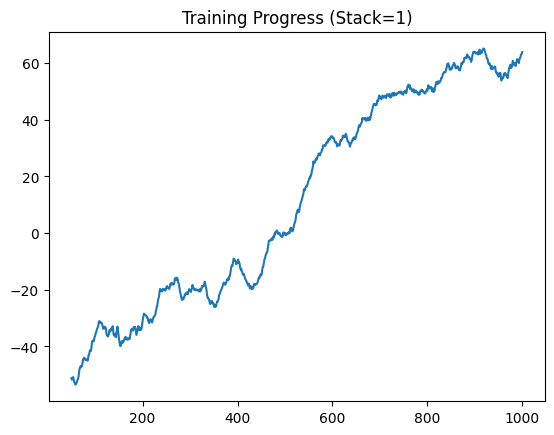

Final SINR: 25.05 dB


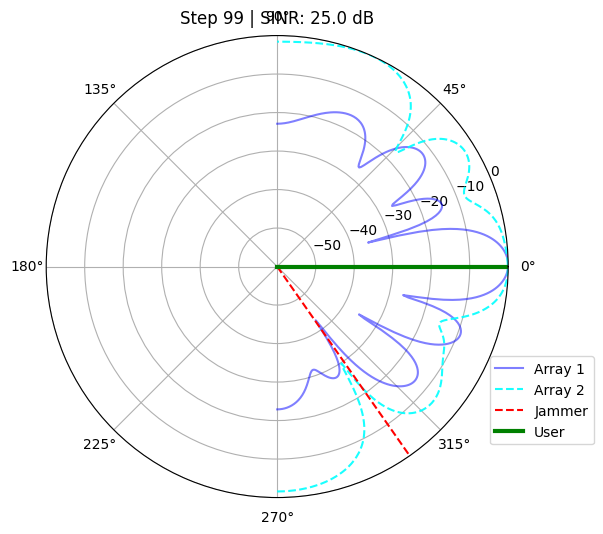

Final SINR: -1.10 dB


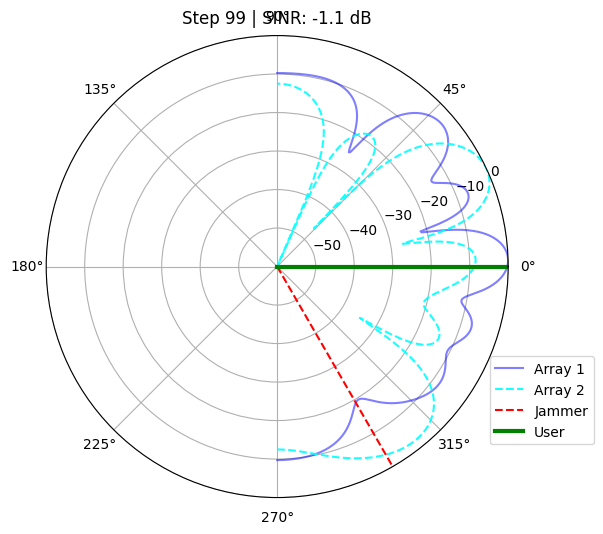

In [14]:
if __name__ == "__main__":
    model_static = train_agent(stack_frames=1, total_steps=300000, print_freq=5000, scenario='sector')
    run_simo_test(model_static, "Static Slow", 10.0, slow_test_trajectory, stack_frames=1)
    run_simo_test(model_static, "Static Fast", 100.0, stress_test_trajectory, stack_frames=1)

In [4]:
if __name__ == "__main__":
    model_temporal = train_agent(stack_frames=5, total_steps=300000, print_freq=5000, scenario='sector')
    run_simo_test(model_temporal, "Temporal Slow", 10.0, slow_test_trajectory, stack_frames=5)
    run_simo_test(model_temporal, "Temporal Fast", 100.0, stress_test_trajectory, stack_frames=5)


--- TRAINING AGENT (STACK=5) ---
Step: 2500 | Mean Reward: -1020.02
Step: 5000 | Mean Reward: -1127.99
Step: 7500 | Mean Reward: -1140.42
Step: 10000 | Mean Reward: -1030.45
Step: 12500 | Mean Reward: -1198.81
Step: 15000 | Mean Reward: -1067.46
Step: 17500 | Mean Reward: -1093.42
Step: 20000 | Mean Reward: -1081.81
Step: 22500 | Mean Reward: -1122.76
Step: 25000 | Mean Reward: -1182.91
Step: 27500 | Mean Reward: -1139.07
Step: 30000 | Mean Reward: -1123.87
Step: 32500 | Mean Reward: -1195.48
Step: 35000 | Mean Reward: -1122.68
Step: 37500 | Mean Reward: -1121.93


KeyboardInterrupt: 

## run_zoom_test

In [ ]:
def run_zoom_test(model, jammer_power=100.0, stack_frames=5):
    print(f"\n--- RUNNING ZOOM DIAGNOSTIC (Power={jammer_power}, Stack={stack_frames}) ---")
    
    def stress_test_trajectory(step):
        return 30.0 + (step * 0.5) % 50.0

    test_env = OptimizedSIMOEnv(
        num_elements=8, 
        trajectory_fn=stress_test_trajectory, 
        randomize_params=False, 
        stack_frames=stack_frames,
        scenario='fixed'
    )
    # Sync physics
    test_env.physics_1.sigma_jammer = jammer_power
    test_env.physics_2.sigma_jammer = jammer_power
    test_env.user_angle = 90.0
    
    obs, _ = test_env.reset()
    history_sinr = []
    
    for step in range(100):
        # Predict using the passed model
        action, _ = model.predict(obs, deterministic=True)
        obs, _, _, _, _ = test_env.step(action)
        
        # Calc Combined SINR
        g_u1 = test_env.physics_1.array_factor_gain(test_env.user_angle, test_env.weights_1)
        g_j1 = test_env.physics_1.array_factor_gain(test_env.jammer_angle, test_env.weights_1)
        sinr1 = g_u1 / (g_j1 * jammer_power + 0.1)
        
        g_u2 = test_env.physics_2.array_factor_gain(test_env.user_angle, test_env.weights_2)
        g_j2 = test_env.physics_2.array_factor_gain(test_env.jammer_angle, test_env.weights_2)
        sinr2 = g_u2 / (g_j2 * jammer_power + 0.1)
        
        history_sinr.append(10*np.log10(sinr1 + sinr2 + 1e-9))

    # --- PLOT ZOOM ---
    plt.figure(figsize=(10, 5))
    
    # Full View
    plt.subplot(1, 2, 1)
    plt.plot(history_sinr, color='purple')
    plt.title("Full Episode (100 Steps)")
    plt.xlabel("Step")
    plt.ylabel("SINR (dB)")
    plt.grid(True, alpha=0.3)
    
    # ZOOM View
    plt.subplot(1, 2, 2)
    zoom_start = 80
    zoom_end = 100
    
    if len(history_sinr) >= zoom_end:
        subset = history_sinr[zoom_start:zoom_end]
        steps_zoom = range(zoom_start, zoom_end)
        plt.plot(steps_zoom, subset, color='red', marker='o')
        plt.title(f"Zoom: Stability Check (Steps {zoom_start}-{zoom_end})")
    else:
        plt.plot(history_sinr, color='red', marker='o')
        plt.title("Zoom: Full Episode (Short)")

    plt.xlabel("Step")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run Zoom Test on the Temporal Model
run_zoom_test(model_static, stack_frames=1)

# BLINDFOLD TEST (Temporal Verdict)

In [ ]:
def run_blind_test_logic(model, stack_frames):
    # Define trajectory
    def stress_test_trajectory(step):
        return 30.0 + (step * 0.5) % 50.0

    # Initialize Env
    env = OptimizedSIMOEnv(
        num_elements=8, 
        trajectory_fn=stress_test_trajectory,
        randomize_params=False,
        stack_frames=stack_frames,
        scenario='fixed'
    )
    env.physics_1.sigma_jammer = 100.0 # High Power
    env.physics_2.sigma_jammer = 100.0
    env.user_angle = 90.0

    obs, _ = env.reset()
    history_gains = []
    
    for step in range(60):
        # === THE BLINDFOLD ===
        if 40 <= step < 50:
            # Feed Zero observation to simulate sensor loss
            blind_obs = np.zeros_like(obs)
            # CRITICAL: We predict using the blind observation
            action, _ = model.predict(blind_obs, deterministic=True)
        else:
            action, _ = model.predict(obs, deterministic=True)
            
        # Physics continues regardless of blindness
        obs, _, _, _, _ = env.step(action)
        
        # Record TRUE physical gain (Performance) of Array 1 at JAMMER angle
        # We want this to be LOW (Deep Null)
        g = env.physics_1.array_factor_gain(env.jammer_angle, env.weights_1)
        history_gains.append(10*np.log10(g + 1e-9))
        
    return history_gains

def run_verdict_test(model_static, model_temporal):
    print("\n--- Running Blindfold Verdict Test ---")
    
    # Run Static Agent (Stack=1)
    gains_static = run_blind_test_logic(model_static, stack_frames=1)
    
    # Run Temporal Agent (Stack=5)
    gains_temp = run_blind_test_logic(model_temporal, stack_frames=5)

    # --- PLOT RESULTS ---
    plt.figure(figsize=(10, 5))
    plt.plot(gains_static, color='red', linestyle='--', label='Static (1 Frame)')
    plt.plot(gains_temp, color='green', linewidth=2, label='Temporal (5 Frames)')

    # Highlight Blind Zone
    plt.axvspan(40, 50, color='gray', alpha=0.3, label='Blindfold Zone')

    plt.title("Verdict: Object Permanence Test\n(Agents Blindfolded steps 40-50)")
    plt.xlabel("Step")
    plt.ylabel("Jammer Gain (dB) [Lower is Better]")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("verdict_plot.png")
    plt.show()

# Run the Verdict
run_verdict_test(model_static, model_temporal)

# validate_swarn.py

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 1. PHYSICS & ENVIRONMENT (Standardized)
# ==========================================
class AntennaArrayPhysics:
    def __init__(self, num_elements):
        self.N = num_elements
        self.d_lambda = 0.5 
        self.k = 2 * np.pi
        self.sigma_signal = 1.0   
        self.sigma_jammer = 10.0  
        self.snapshots = 64       

    def steering_vector(self, theta_deg):
        theta_rad = np.radians(theta_deg)
        n = np.arange(self.N)
        psi = self.k * self.d_lambda * np.cos(theta_rad)
        return np.exp(1j * n.reshape(-1, 1) * psi)

    def compute_scm(self, theta_user, theta_jammer):
        a_user = self.steering_vector(theta_user)
        a_jam = self.steering_vector(theta_jammer)
        # Random complex noise
        s_user = (np.random.randn(1, self.snapshots) + 1j * np.random.randn(1, self.snapshots)) * np.sqrt(self.sigma_signal/2)
        s_jam = (np.random.randn(1, self.snapshots) + 1j * np.random.randn(1, self.snapshots)) * np.sqrt(self.sigma_jammer/2)
        noise = (np.random.randn(self.N, self.snapshots) + 1j * np.random.randn(self.N, self.snapshots)) * np.sqrt(0.1/2)
        X = (a_user @ s_user) + (a_jam @ s_jam) + noise
        Rxx = (X @ X.conj().T) / self.snapshots
        return Rxx

    def array_factor_gain(self, theta_deg, weights):
        a = self.steering_vector(theta_deg)
        return np.abs(np.sum(np.conj(weights) * a.flatten()))**2

# Trajectories
def stress_test_trajectory(step):
    return 30.0 + (step * 0.5) % 50.0 # Fast

def training_trajectory(step):
    return 20.0 + (step * 0.05) % 50.0 # Slow

# Optimized Environment
class OptimizedSIMOEnv(gym.Env):
    def __init__(self, num_elements=8, trajectory_fn=training_trajectory, randomize_params=True, stack_frames=5):
        super(OptimizedSIMOEnv, self).__init__() 
        self.N = num_elements
        self.num_arrays = 2 
        self.physics_1 = AntennaArrayPhysics(num_elements=self.N)
        self.physics_2 = AntennaArrayPhysics(num_elements=self.N)
        self.trajectory_fn = trajectory_fn
        self.randomize_params = randomize_params
        self.stack_frames = stack_frames
        
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(self.N * self.num_arrays,), dtype=np.float32)
        single_obs_dim = (self.N) + (self.N * 2) 
        self.stacked_obs_dim = single_obs_dim * self.num_arrays * self.stack_frames
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(self.stacked_obs_dim,), dtype=np.float32)
        
        self.obs_buffer = deque(maxlen=self.stack_frames)
        self.phases_1 = np.zeros(self.N, dtype=np.float32)
        self.phases_2 = np.zeros(self.N, dtype=np.float32)
        self.step_count = 0
        self.jammer_angle = 30.0
        self.user_angle = 90.0
        self.jammer_velocity = 0.05 

    def _get_frame(self):
        # Array 1
        R1 = self.physics_1.compute_scm(self.user_angle, self.jammer_angle)
        scale1 = np.trace(R1).real + 1e-6
        row1 = (R1 / scale1)[0, :]
        # Array 2
        R2 = self.physics_2.compute_scm(self.user_angle, self.jammer_angle)
        scale2 = np.trace(R2).real + 1e-6
        row2 = (R2 / scale2)[0, :]
        
        return np.concatenate([self.phases_1, self.phases_2, row1.real, row1.imag, row2.real, row2.imag]).astype(np.float32)

    def _get_obs(self):
        while len(self.obs_buffer) < self.stack_frames:
            self.obs_buffer.append(self._get_frame())
        return np.concatenate(list(self.obs_buffer)).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        self.phases_1 = np.zeros(self.N, dtype=np.float32)
        self.phases_2 = np.zeros(self.N, dtype=np.float32)
        self.obs_buffer.clear()
        
        if self.randomize_params:
            self.physics_1.sigma_jammer = float(np.random.randint(20, 80))
            self.physics_2.sigma_jammer = self.physics_1.sigma_jammer
            self.jammer_angle = float(np.random.randint(20, 60))
            self.jammer_velocity = np.random.uniform(-0.6, 0.6)
        else:
            self.jammer_angle = self.trajectory_fn(0)
            self.jammer_velocity = 0.0
            
        initial = self._get_frame()
        for _ in range(self.stack_frames):
            self.obs_buffer.append(initial)
        return self._get_obs(), {}

    def step(self, action):
        self.phases_1 = (self.phases_1 + action[:self.N] + np.pi) % (2*np.pi) - np.pi
        self.phases_2 = (self.phases_2 + action[self.N:] + np.pi) % (2*np.pi) - np.pi
        
        # Physics Update
        self.step_count += 1
        if self.randomize_params:
            self.jammer_angle += self.jammer_velocity
            if self.jammer_angle > 180: self.jammer_angle = 180
            if self.jammer_angle < 0: self.jammer_angle = 0
        else:
            self.jammer_angle = self.trajectory_fn(self.step_count)
            
        self.obs_buffer.append(self._get_frame())
        
        # Calculation for Reward
        w1 = np.exp(1j * self.phases_1)
        w2 = np.exp(1j * self.phases_2)
        # Check surrounding angles for Robustness
        angles = [self.jammer_angle - 1.0, self.jammer_angle, self.jammer_angle + 1.0]
        
        max_jam1 = max([self.physics_1.array_factor_gain(a, w1) for a in angles])
        sinr1 = (self.physics_1.array_factor_gain(90, w1)) / (max_jam1 * self.physics_1.sigma_jammer + 0.1)
        
        max_jam2 = max([self.physics_2.array_factor_gain(a, w2) for a in angles])
        sinr2 = (self.physics_2.array_factor_gain(90, w2)) / (max_jam2 * self.physics_2.sigma_jammer + 0.1)
        
        reward = 10 * np.log10(sinr1 + sinr2 + 1e-9) - 0.01 * np.sum(np.abs(action)**2)
        return self._get_obs(), np.clip(reward, -20, 20), False, self.step_count >= 100, {}

# ==========================================
# 2. PLOTTING TOOLS (The Missing Piece)
# ==========================================
def plot_simo_polar(physics, weights1, weights2, jammer_angle, step_num, combined_sinr, save_path=None):
    theta_physics = np.linspace(0, 180, 360)
    
    # Array 1 Pattern
    w1 = np.exp(1j * weights1)
    gains1 = np.array([physics.array_factor_gain(th, w1) for th in theta_physics])
    gains_db1 = 10 * np.log10(gains1 / (np.max(gains1) + 1e-9) + 1e-9)
    gains_db1 = np.clip(gains_db1, -60, 0)
    
    # Array 2 Pattern
    w2 = np.exp(1j * weights2)
    gains2 = np.array([physics.array_factor_gain(th, w2) for th in theta_physics])
    gains_db2 = 10 * np.log10(gains2 / (np.max(gains2) + 1e-9) + 1e-9)
    gains_db2 = np.clip(gains_db2, -60, 0)
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, projection='polar')
    theta_plot = np.radians(theta_physics - 90)
    
    ax.plot(theta_plot, gains_db1, color='blue', linewidth=2, label='Array 1', alpha=0.5)
    ax.plot(theta_plot, gains_db2, color='cyan', linewidth=2, linestyle='--', label='Array 2', alpha=0.9)
    
    # Markers
    ax.axvline(np.radians(90 - 90), color='green', lw=3, label='User')
    ax.axvline(np.radians(jammer_angle - 90), color='red', ls='--', lw=2, label='Jammer')
    
    ax.set_ylim(-60, 0)
    ax.set_rticks([-20, -40])
    ax.set_title(f"Step {step_num} | SINR: {combined_sinr:.1f} dB", va='bottom')
    ax.legend(loc='lower right', bbox_to_anchor=(1.2, 0.1))
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

# ==========================================
# 3. SWARM VALIDATION RUNNER
# ==========================================
def train_and_validate_swarm(n_seeds=3, train_steps=100000):
    print(f"--- STARTING SWARM VALIDATION ({n_seeds} Independent Agents) ---")
    
    swarm_results = []
    
    for seed in range(n_seeds):
        print(f"\nTraining Agent {seed+1}/{n_seeds}...")
        
        # 1. Train
        env = OptimizedSIMOEnv(num_elements=8, randomize_params=True, stack_frames=5)
        env.reset(seed=seed) # Important: Different seed
        
        n_actions = env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.01 * np.ones(n_actions))
        model = SAC("MlpPolicy", env, action_noise=action_noise, verbose=0, seed=seed)
        
        # Shorter training for demonstration (Use 300k for final paper)
        model.learn(total_timesteps=train_steps) 
        
        # 2. Test on Stress Scenario
        test_env = OptimizedSIMOEnv(
            num_elements=8, 
            trajectory_fn=stress_test_trajectory, 
            randomize_params=False, 
            stack_frames=5
        )
        test_env.physics_1.sigma_jammer = 100.0 # High Power
        test_env.physics_2.sigma_jammer = 100.0
        
        obs, _ = test_env.reset()
        history_sinr = []
        last_weights = (None, None)
        last_jam = 0
        
        for step in range(100):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, _, _, _ = test_env.step(action)
            
            # Recalc Metrics
            w1 = np.exp(1j * test_env.phases_1)
            w2 = np.exp(1j * test_env.phases_2)
            jam = test_env.jammer_angle
            
            g1 = test_env.physics_1.array_factor_gain(90, w1) / (test_env.physics_1.array_factor_gain(jam, w1)*100.0 + 0.1)
            g2 = test_env.physics_2.array_factor_gain(90, w2) / (test_env.physics_2.array_factor_gain(jam, w2)*100.0 + 0.1)
            
            combined_db = 10*np.log10(g1 + g2 + 1e-9)
            history_sinr.append(combined_db)
            
            if step == 99:
                last_weights = (test_env.phases_1, test_env.phases_2)
                last_jam = jam

        swarm_results.append(history_sinr)
        
        # Save Polar Plot for this agent
        print(f"Agent {seed+1} Final SINR: {history_sinr[-1]:.2f} dB")
        plot_simo_polar(test_env.physics_1, last_weights[0], last_weights[1], last_jam, 99, history_sinr[-1], save_path=f"agent_{seed}_polar.png")

    return np.array(swarm_results)

# ==========================================
# 4. EXECUTE & PLOT AGGREGATE
# ==========================================
# if __name__ == "__main__":
#     # Run Swarm (Use 150k+ steps for real results, 50k for quick check)
#     results_matrix = train_and_validate_swarm(n_seeds=3, train_steps=100000)
    
#     # Calculate Stats
#     mean_curve = np.mean(results_matrix, axis=0)
#     std_curve = np.std(results_matrix, axis=0)
#     steps = np.arange(len(mean_curve))
    
#     # Plot Confidence Interval
#     plt.figure(figsize=(10, 6))
#     plt.plot(steps, mean_curve, color='green', linewidth=2, label='Mean SINR (Swarm)')
#     plt.fill_between(steps, mean_curve - std_curve, mean_curve + std_curve, color='green', alpha=0.2, label='Std Dev')
    
#     plt.axhline(10, ls='--', color='gray', label='Target (10dB)')
#     plt.title("Swarm Validation: Performance Stability across 3 Independent Agents")
#     plt.xlabel("Step (Fast Stress Test)")
#     plt.ylabel("SINR (dB)")
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.savefig("swarm_validation_result.png")
#     plt.show()
    
#     print("Swarm Validation Complete. Check 'swarm_validation_result.png'.")